# Chapter 14: The Social Survey case study

## Download the zip file and build a DataFrame for the metadata 

### Download GSS zip file

In [1]:
import pandas as pd
import seaborn as sns
from urllib import request   
from zipfile import ZipFile
import pyreadstat

In [2]:
zip_url = 'https://www.murach.com/python_analysis/gss_stata_with_codebook.zip'
request.urlretrieve(zip_url, filename='gss_stata_with_codebook.zip')

('gss_stata_with_codebook.zip', <http.client.HTTPMessage at 0x1fa80edd4c0>)

### Unzip the zip file

In [3]:
with ZipFile('gss_stata_with_codebook.zip', mode='r') as zip:
    zip.extractall() 
    for file in zip.infolist():    
        print(f'{file.filename:25} - {file.file_size:15,d} Bytes')

Release Notes 7218.pdf    -         296,746 Bytes
GSS_Codebook.pdf          -      37,952,897 Bytes
GSS7218_R3.DTA            -     449,140,819 Bytes


### Build a DataFrame for the metadata

In [4]:
gss_empty, gss_meta = pyreadstat.read_dta('GSS7218_R3.DTA', metadataonly=True)

In [5]:
print('Number of columns: ', gss_meta.number_columns)
print('Number of rows: ',gss_meta.number_rows)

Number of columns:  6110
Number of rows:  64814


In [6]:
meta_cols=pd.DataFrame(data=gss_meta.column_labels,
                       index=gss_meta.column_names, 
                       columns=['description'])
meta_cols

,description
year,gss year for this respondent
id,respondent id number
wrkstat,labor force status
hrs1,number of hours worked last week
hrs2,number of hours usually work a week
...,...
wtss,weight variable
wtssnr,weight variable
wtssall,weight variable
vstrat,variance stratum


## Read the data into a DataFrame

In [7]:
workStatus = pd.read_stata('GSS7218_R3.DTA', columns=['id','year','wrkstat'])

In [8]:
workStatus.head()

,id,year,wrkstat
0,1,1972,working fulltime
1,2,1972,retired
2,3,1972,working parttime
3,4,1972,working fulltime
4,5,1972,keeping house


## Prepare the data

In [9]:
workStatus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64814 entries, 0 to 64813
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       64814 non-null  int16   
 1   year     64814 non-null  int16   
 2   wrkstat  64793 non-null  category
dtypes: category(1), int16(2)
memory usage: 317.0 KB


In [10]:
workStatus['wrkstat'].value_counts(dropna=False)

wrkstat
working fulltime    31892
keeping house       10176
retired              9121
working parttime     6719
unempl, laid off     2179
school               1998
temp not working     1363
other                1345
NaN                    21
Name: count, dtype: int64

In [11]:
# old code
# statusCounts = workStatus.groupby(by=['year', 'wrkstat'], as_index=False).count()
# future warning regarding observed parameter, fixed by adding observed=True to the groupby call
statusCounts = workStatus.groupby(by=['year', 'wrkstat'], observed=True, as_index=False).count()
statusCounts.columns = ['year', 'wrkstat', 'counts']
statusCounts.head()

,year,wrkstat,counts
0,1972,working fulltime,750
1,1972,working parttime,121
2,1972,temp not working,38
3,1972,"unempl, laid off",46
4,1972,retired,144


## Plot the data and reduce the number of categories

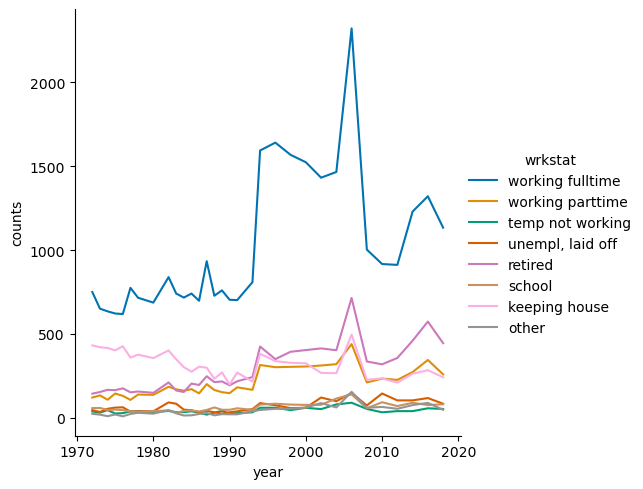

In [12]:
sns.relplot(data=statusCounts, x='year', y='counts', hue='wrkstat', 
            kind='line', palette='colorblind')

In [13]:
topCounts = statusCounts.query(
    'wrkstat in ["working fulltime", "working parttime", "retired", \
    "unempl, laid off"]').copy()
topCounts.wrkstat.value_counts()

wrkstat
working fulltime    32
working parttime    32
unempl, laid off    32
retired             32
temp not working     0
school               0
keeping house        0
other                0
Name: count, dtype: int64

In [14]:
topCounts.wrkstat = topCounts.wrkstat.cat.remove_unused_categories()
topCounts.wrkstat.value_counts()

wrkstat
working fulltime    32
working parttime    32
unempl, laid off    32
retired             32
Name: count, dtype: int64

## Plot the total counts of the responses

In [15]:
# add yearly totals
# old code
# topCountsByYear = topCounts.groupby(by=['year'], as_index=False).sum()
# improper aggregate call sequence, fixed by selecting needed data before aggregating
topCountsByYear = topCounts.groupby(by=['year'], as_index=False)[['counts']].sum()
topCountsByYear.head()

,year,counts
0,1972,1061
1,1973,974
2,1974,964
3,1975,993
4,1976,989


In [16]:
# old code 
# topCounts = topCounts.merge(topCountsByYear, on='year')
# error due to missing suffix parameter, added it to avoid a column name collision
topCounts = topCounts.merge(topCountsByYear, on='year', suffixes=('','Total'))
topCounts.head()

,year,wrkstat,counts,countsTotal
0,1972,working fulltime,750,1061
1,1972,working parttime,121,1061
2,1972,"unempl, laid off",46,1061
3,1972,retired,144,1061
4,1973,working fulltime,651,974


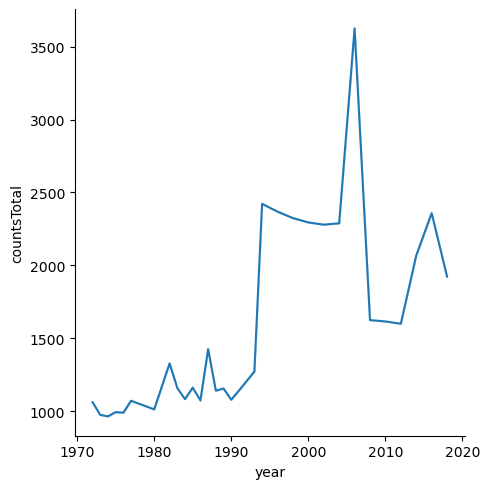

In [17]:
# error
# updated the y parameter to reflect the new column names given in the previous cell
sns.relplot(data=topCounts, x='year', y='countsTotal', 
            kind='line')

## Convert the counts to percents and plot them

In [18]:
topCounts['percent'] = topCounts.counts / topCounts.countsTotal
topCounts.head()

,year,wrkstat,counts,countsTotal,percent
0,1972,working fulltime,750,1061,0.706880
1,1972,working parttime,121,1061,0.114043
2,1972,"unempl, laid off",46,1061,0.043355
3,1972,retired,144,1061,0.135721
4,1973,working fulltime,651,974,0.668378


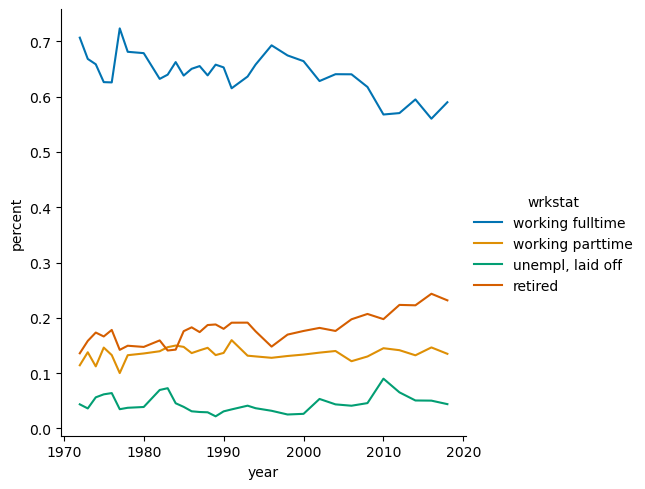

In [19]:
# This chart makes more sense
sns.relplot(data=topCounts, x='year', y='percent', kind='line', 
            hue='wrkstat', palette='colorblind')

## Read and review the work-life data

In [20]:
# pg 3103, work life balance questions
wlBalanceCols = ['wkcontct','talkspvs','effctsup']
wlBalance = pd.read_stata('GSS7218_R3.DTA', columns=wlBalanceCols).dropna()
wlBalance

,wkcontct,talkspvs,effctsup
57062,once or twice a month,very,very
57064,never,very,very
57074,never,very,somewhat
57079,never,somewhat,very
57081,never,very,very
...,...,...,...
59591,once or twice a month,somewhat,somewhat
59595,less than once a month,very,very
59596,never,somewhat,somewhat
59597,once or twice a month,a little,somewhat


In [21]:
wlBalance.wkcontct.value_counts()

wkcontct
never                      329
less than once a month     187
once or twice a month      170
several times a week       145
once a week                 98
two or more times a day     42
once a day                  29
Name: count, dtype: int64

In [22]:
wlBalance.talkspvs.value_counts()

talkspvs
very                      333
somewhat                  259
extremely                 165
not at all comfortable    127
a little                  116
Name: count, dtype: int64

In [23]:
wlBalance.effctsup.value_counts()

effctsup
very                    338
somewhat                287
a little                158
extremely               125
not at all effective     92
Name: count, dtype: int64

## Plot the work-life responses for the first question

In [24]:
workContact = wlBalance.wkcontct.value_counts().to_frame().reset_index()
workContact.columns = ['answer','count']
workContact

,answer,count
0,never,329
1,less than once a month,187
2,once or twice a month,170
3,several times a week,145
4,once a week,98
5,two or more times a day,42
6,once a day,29


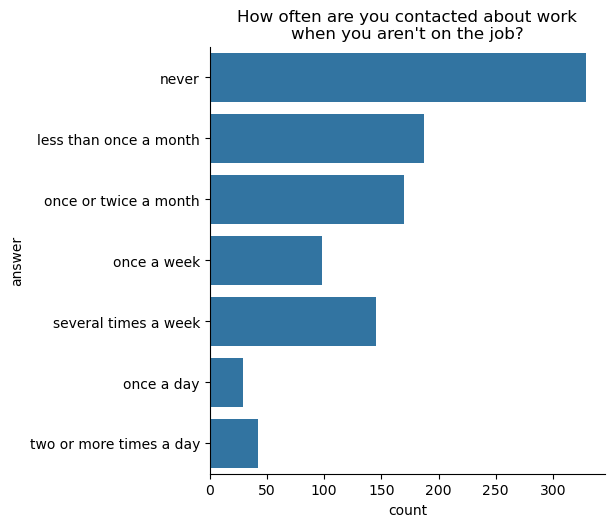

In [25]:
g = sns.catplot(data=workContact, x='count', y='answer', 
                kind='bar', orient='h', aspect=1.25)

g.set(title="How often are you contacted about work\n" + 
            "when you aren't on the job?")

## Plot the work-life responses for the second and third questions

In [26]:
df1 = wlBalance.talkspvs.value_counts().to_frame()
df1 = df1.rename(index={'not at all comfortable':'not at all'}) 
df1

,count
talkspvs,
very,333
somewhat,259
extremely,165
not at all,127
a little,116


In [27]:
df2 = wlBalance.effctsup.value_counts().to_frame()
df2 = df2.rename(index={'not at all effective':'not at all'})
df2

,count
effctsup,
very,338
somewhat,287
a little,158
extremely,125
not at all,92


In [28]:
supervisorData = df1.join(df2).reset_index()
supervisorData.head()

ValueError: columns overlap but no suffix specified: Index(['count'], dtype='object')

In [ ]:
supervisorData = pd.melt(supervisorData, id_vars='index', 
                         value_vars=['talkspvs', 'effctsup'])
supervisorData.columns = ['answer','question','responseCount']
supervisorData.head()

In [ ]:
g = sns.catplot(data=supervisorData, x='answer', y='responseCount', 
                kind='bar', col='question', aspect=1.25, col_wrap=2)

titles = ['How comfortable are you talking with your supervisor?',
          'How helpful is your supervisor at resolving work-life conflicts?']
for i, ax in enumerate(g.axes.flat):
    ax.tick_params('x',labelrotation=45)
    ax.set_title(titles[i])

## Select the columns for an expanded DataFrame

In [ ]:
workCols = ['year', 'sex', 'region', 'wrkstat', 'hrs1', 'wkcontct', 
    'talkspvs', 'effctsup']
workData = pd.read_stata('GSS7218_R3.DTA', columns=workCols) \
    .dropna(axis=0).reset_index(drop=True)
workData

In [ ]:
workData.year.value_counts()

In [ ]:
workData.hrs1.head()

## Bin the data for a column

In [ ]:
# convert hrs1 from category type to str type to float type
workData.hrs1 = workData.hrs1.astype(str).replace('89+ hrs','89').astype(float)
workData.hrs1.head()

In [ ]:
binLabels = [f'{i}-{i+9} hours' for i in range(0,90,10)]
binLabels

In [ ]:
workData.hrs1 = pd.cut(workData.hrs1, 
                       bins=[0,10,20,30,40,50,60,70,80,90], right=False, 
                       labels=binLabels)
workData.head()

## Develop and test the first hypothesis

### Hpypothesis

### Test

In [ ]:
workData.sex.value_counts()

In [ ]:
# drop 58 female respondents to get an equal number of male and female respondents
workData = workData.sort_values('sex', ascending=False).iloc[58:]

In [ ]:
workData.sex.value_counts()

In [ ]:
responses = ['once a day','two or more times a day']
df = workData.query('wkcontct in @responses').copy()
df.wkcontct = df.wkcontct.cat.remove_unused_categories()
df.head()

In [ ]:
g = sns.catplot(data=df, x='sex', col='wkcontct', kind='count')
g.fig.suptitle('Are men contacted more on a daily basis in non-working hours?',
               y=1.035)

### Conclusion

## Develop and test the second hypothesis

### Hypothesis

### Test

In [ ]:
workPivot = workData[['year','hrs1','talkspvs']].pivot_table(
    columns='hrs1', index='talkspvs', aggfunc='count')
workPivot = workPivot.droplevel(0, axis=1)   # the top column level isn’t needed
workPivot.head()

In [ ]:
ax = sns.heatmap(workPivot, cmap='Blues', annot=True, fmt='.3g')
ax.set_title(
    "Do those who don't like to talk with their supervisors work more hours?\n")
ax.set(xlabel='', ylabel='How comfortable talking with supervisor?')

### Conclusion

## Develop and test the third hypothesis

### Hypothesis

### Test

In [ ]:
responses = ['very','somewhat','extremely']
df = workData.query('effctsup in @responses').copy()
df.effctsup = df.effctsup.cat.remove_unused_categories()

g = sns.catplot(data=df, x='sex', col='effctsup', kind='count', col_wrap=2)
g.fig.suptitle('How effective is your supervisor at helping you resolve ' +
               'work-life conflicts?', y=1.025)

### Conclusion